In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from zipfile import ZipFile
import torch
import torch.nn as nn
import time
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import random
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from operator import add

In [ ]:
np.random.seed(10);

In [ ]:
with ZipFile("DRIVE.zip", 'r') as file:
    file.printdir()
    file.extractall()
    print('Done!')

In [ ]:
def loadData(path):

  train = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
  mask = sorted(glob(os.path.join(path,"training", "1st_manual", "*.gif")))

  test = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
  testMask = sorted(glob(os.path.join(path,"test", "mask", "*.gif")))

  return (train, mask), (test, testMask)

In [ ]:
dataPath = "DRIVE"
(train, mask), (test, testMask) = loadData(dataPath)

In [ ]:
paths = ["new_data/train/image/","new_data/train/masks/","new_data/test/image/","new_data/test/masks/"]
for path in paths:
  if not os.path.exists(path):
    os.makedirs(path)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-15-0630506adcbf>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,5,ids+1)
100%|██████████| 20/20 [00:00<00:00, 22.29it/s]


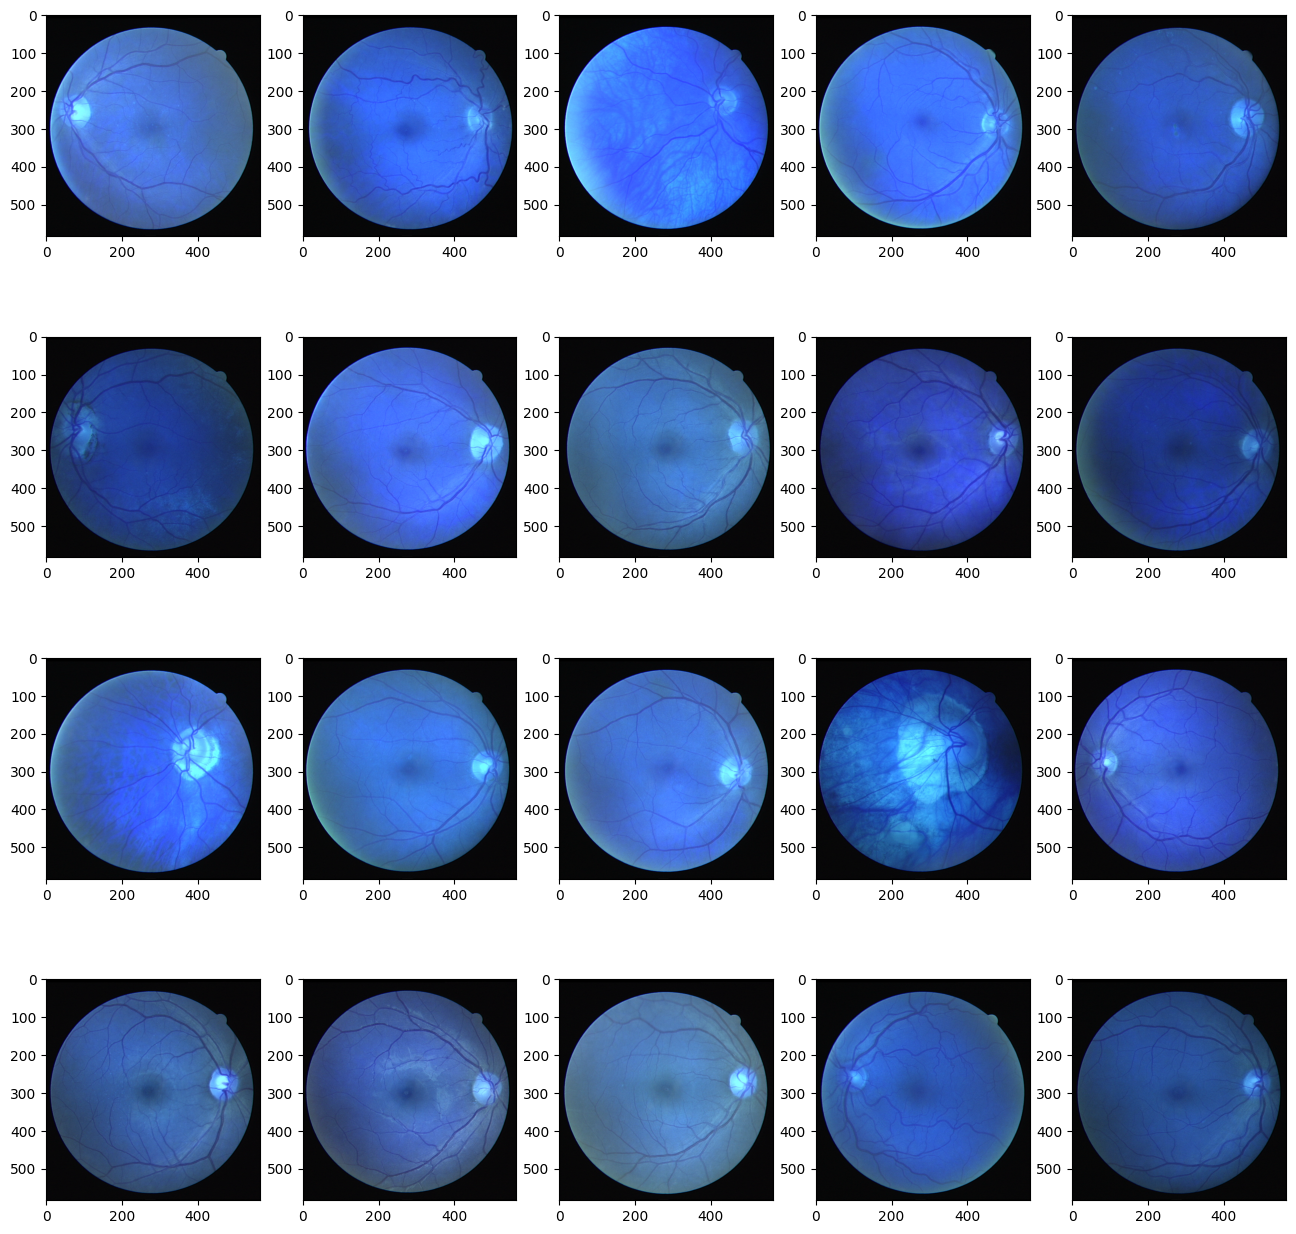

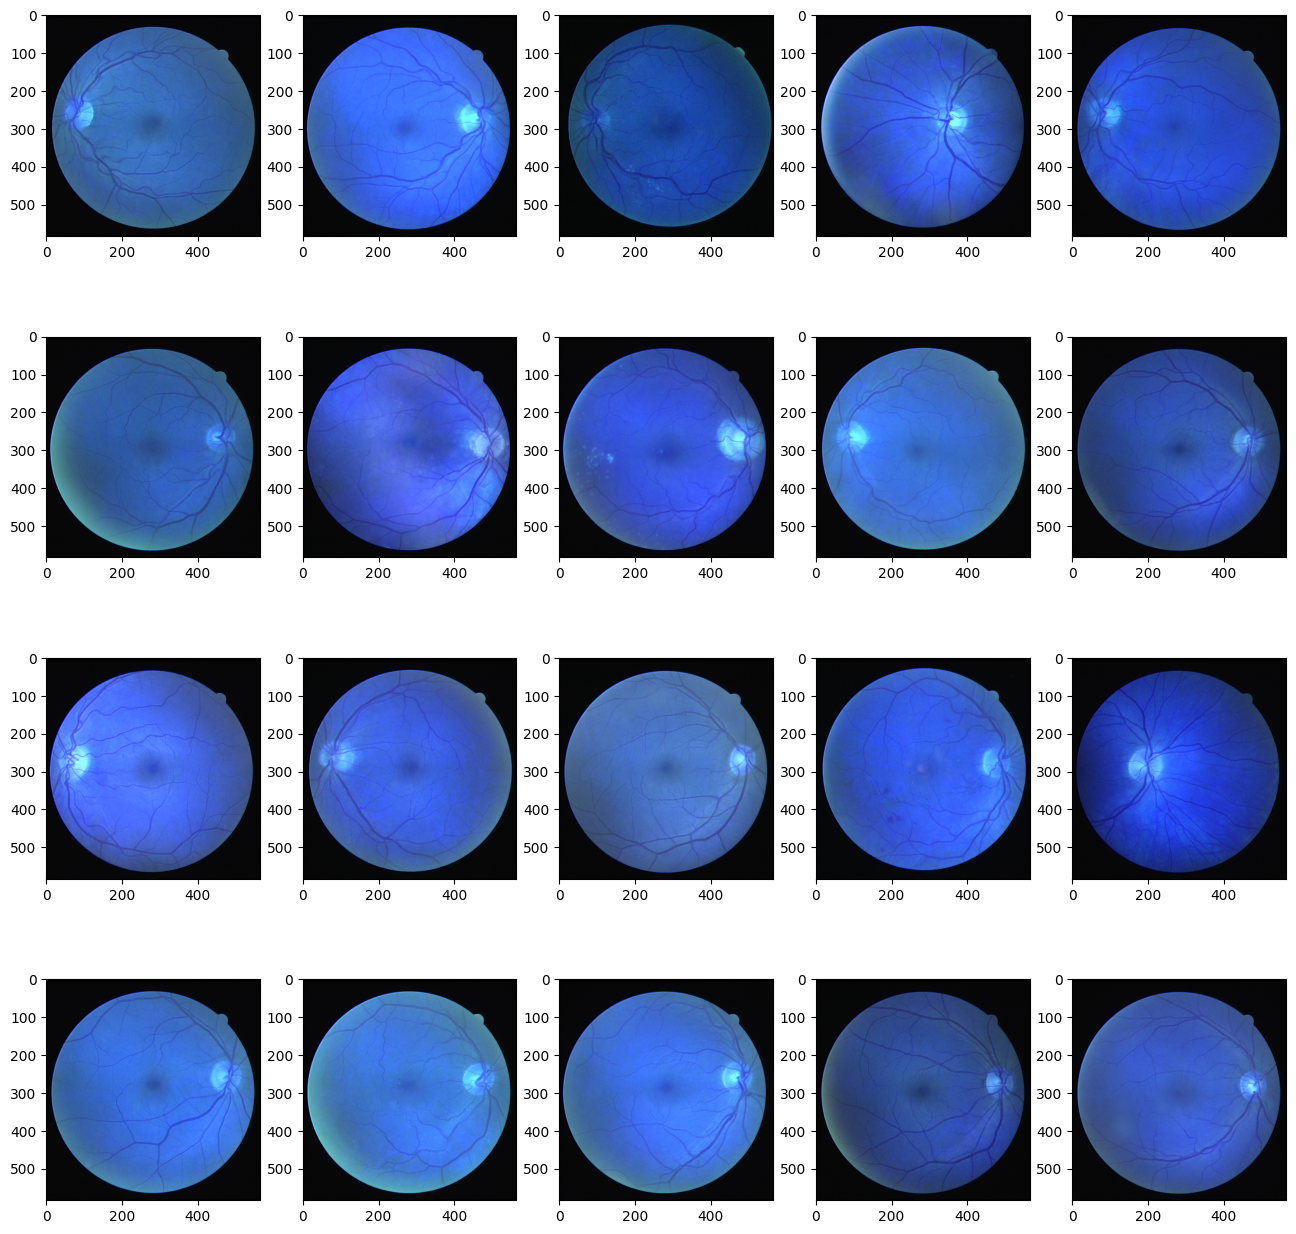

In [ ]:
def data_augmentation(images, masks, path, augment_data = True):

  plt.figure(figsize=(16,16))
  plt.axis(None)

  for ids, (x,y) in tqdm(enumerate(zip(images, masks)), total = len(images)):

    image_name = x.split('/')[-1].split('.')[0]
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    y = imageio.mimread(y)[0]
    plt.subplot(4,5,ids+1)
    plt.imshow(x)

    if augment_data:
      augmentation = HorizontalFlip(p=1)
      augmentation = augmentation(image = x, mask = y)
      x1 = augmentation['image']
      y1 = augmentation['mask']

      augmentation = VerticalFlip(p=1)
      augmentation = augmentation(image = x, mask = y)
      x2 = augmentation['image']
      y2 = augmentation['mask']

      augmentation = Rotate(limit=50,p=1)
      augmentation = augmentation(image = x, mask = y)
      x3 = augmentation['image']
      y3 = augmentation['mask']

      x_data = [x,x1,x2,x3]
      y_data = [y,y1,y2,y3]

    else:
      x_data = [x]
      y_data = [y]

    index = 0;

    for img, m in zip(x_data,y_data):

      img = cv2.resize(img, (512,512))
      m = cv2.resize(m, (512,512))

      img_path = os.path.join(path,"image",image_name+'_'+str(index)+".png")
      mask_path = os.path.join(path,"masks",image_name+'_'+str(index)+".png")

      cv2.imwrite(img_path, img)
      cv2.imwrite(mask_path,m)

      index += 1





data_augmentation(train, mask, "new_data/train/")
data_augmentation(test, testMask, "new_data/test/", False)

In [ ]:
# UNET
class conv(nn.Module):
    def __init__(self, in_channels, out_channels):
      super().__init__()

      self.conv1 = nn.Conv2d(in_channels, out_channels,3,padding = 1)
      self.btc1 = nn.BatchNorm2d(out_channels)

      self.conv2 = nn.Conv2d(out_channels, out_channels,3,padding = 1)
      self.btc2 = nn.BatchNorm2d(out_channels)

      self.relu = nn.ReLU()

    def forward(self, x):
      x = self.conv1(x)
      x = self.btc1(x)
      x = self.relu(x)

      x = self.conv2(x)
      x = self.btc2(x)
      x = self.relu(x)

      return x


In [ ]:
class encoder(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.conv = conv(in_channels,out_channels)
    self.mxp = nn.MaxPool2d(2)
  def forward(self,input):
    x = self.conv(input)
    p = self.mxp(x)

    return x, p

In [ ]:
class decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, 2)
        self.conv = conv(out_channels+out_channels, out_channels)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [ ]:
class unet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder(3, 64)
        self.e2 = encoder(64, 128)
        self.e3 = encoder(128, 256)
        self.e4 = encoder(256, 512)

        self.b = conv(512, 1024)

        self.d1 = decoder(1024, 512)
        self.d2 = decoder(512, 256)
        self.d3 = decoder(256, 128)
        self.d4 = decoder(128, 64)

        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

In [ ]:
x = torch.randn((2, 3, 512, 512))
f = unet()
y = f(x)
print(y.shape)

torch.Size([2, 1, 512, 512])


In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [ ]:
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0
        image = np.transpose(image, (2, 0, 1))
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255











        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

In [ ]:
def train(model, loader, optimizer, loss_fn):
    epoch_loss = 0.0
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [ ]:
def evaluate(model, loader, loss_fn):
    epoch_loss = 0.0
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [ ]:
seeding(42)
if not os.path.exists("files"):
  os.makedirs("files")

train_x = sorted(glob("new_data/train/image/*"))
train_y = sorted(glob("new_data/train/masks/*"))

valid_x = sorted(glob("new_data/test/image/*"))
valid_y = sorted(glob("new_data/test/masks/*"))

data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print(data_str)

Dataset Size:
Train: 80 - Valid: 20



In [ ]:
H = 512
W = 512
size = (H, W)
batch_size = 2
num_epochs = 100
lr = .000035
checkpoint_path = "files/checkpoint.pth"

train_dataset = DriveDataset(train_x, train_y)
valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count())

valid_loader = DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=False,num_workers= os.cpu_count())

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = unet()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

best_valid_loss = float("inf")

for epoch in tqdm(range(num_epochs)):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_fn)
    valid_loss = evaluate(model, valid_loader, loss_fn)

    if valid_loss < best_valid_loss:
        data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
        print(data_str)

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
    print(data_str)

In [ ]:
def calculate_metrics(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

In [ ]:
def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

In [ ]:
seeding(42)
if not os.path.exists("results"):
  os.makedirs("results")

test_x = sorted(glob("new_data/test/image/*"))
test_y = sorted(glob("new_data/test/masks/*"))

H = 512
W = 512
size = (W, H)
if not os.path.exists("files/checkpoint.pth"):
  os.makedirs("files/checkpoint.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = unet()
model = model.to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
time_taken = []

for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
    name = x.split("/")[-1].split(".")[0]

    image = cv2.imread(x, cv2.IMREAD_COLOR)
    x = np.transpose(image, (2, 0, 1))
    x = x/255.0
    x = np.expand_dims(x, axis=0)
    x = x.astype(np.float32)
    x = torch.from_numpy(x)
    x = x.to(device)

    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    y = np.expand_dims(mask, axis=0)
    y = y/255.0
    y = np.expand_dims(y, axis=0)
    y = y.astype(np.float32)
    y = torch.from_numpy(y)
    y = y.to(device)

    with torch.no_grad():
        start_time = time.time()
        pred_y = model(x)
        pred_y = torch.sigmoid(pred_y)
        total_time = time.time() - start_time
        time_taken.append(total_time)


        score = calculate_metrics(y, pred_y)
        metrics_score = list(map(add, metrics_score, score))
        pred_y = pred_y[0].cpu().numpy()
        pred_y = np.squeeze(pred_y, axis=0)
        pred_y = pred_y > 0.5
        pred_y = np.array(pred_y, dtype=np.uint8)

    ori_mask = mask_parse(mask)
    pred_y = mask_parse(pred_y)
    line = np.ones((size[1], 10, 3)) * 128

    cat_images = np.concatenate(
        [image, line, ori_mask, line, pred_y * 255], axis=1
    )
    cv2.imwrite(f"results/{name}.png", cat_images)

jaccard = metrics_score[0]/len(test_x)
f1 = metrics_score[1]/len(test_x)
recall = metrics_score[2]/len(test_x)
precision = metrics_score[3]/len(test_x)
acc = metrics_score[4]/len(test_x)
print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

fps = 1/np.mean(time_taken)
print("FPS: ", fps)